# Imports

In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    import os
    os.kill(os.getpid(), 9)
    # source: https://stackoverflow.com/a/60237923/2142093

matplotlib: 3.7.0


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00
time: 395 µs (started: 2023-02-21 12:37:09 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense,
    Dropout, Input, Concatenate, GlobalAveragePooling2D
)
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.4 s (started: 2023-02-21 12:37:09 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 881
ETL_DATASET = 'etl_8G'
DNN_NAME = 'DenseNet121'

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'inverted' # o también inverted

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/' \
            + TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print()
print('versión Keras:', keras.__version__) # versión Keras: 2.8.0

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_{}/splits/inverted_otsu/

versión Keras: 2.11.0
time: 1.08 ms (started: 2023-02-21 12:37:12 +00:00)


In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 53.3 s (started: 2023-02-21 12:37:12 +00:00)


# Funciones

In [6]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG: regular o inverted

    Output:
    - np arrays for training and validation images
    '''

    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_8G.npz'
        train_name_labels = 'train_labels_8G.npz'
        val_name_img = 'val_imgs_8G.npz'
        val_name_labels = 'val_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_8G.npz'
        train_name_labels = 'train_inv_labels_8G.npz'
        val_name_img = 'val_inv_imgs_8G.npz'
        val_name_labels = 'val_inv_labels_8G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_8G.npz'
        test_name_labels = 'test_labels_8G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_8G.npz'
        test_name_labels = 'test_inv_labels_8G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL):

    image_input = Input(shape=(WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL))
    img_conc = Concatenate()([image_input, image_input, image_input])

    m_DenseNet121_8G = keras.applications.DenseNet121(
        include_top=False,
        input_tensor=img_conc,
        weights='imagenet',
    )

    last_layer = m_DenseNet121_8G.layers[-1].output
    x = GlobalAveragePooling2D()(last_layer)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x)
    custom_model = Model(image_input, out)

    # freeze all the layers except the 2 newly added layers
    for layer in custom_model.layers[:-2]:
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    '''Recuperar una lista de resultados de la lista de datos de los conjuntos 
    de entrenamiento y pruebas para cada epoch de entrenamiento.
    '''

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG):
    '''Guardar el modelo en disco duro
    
    Args:
        -SIZE: 64, 96, 112 ó 127
        -TFM_PATH = Ruta en drive a la carpeta del TFM
        -custom_model = Modelo de Deep Learning
        -TYPE_IMG = regular o inverted
        -USE_DATA_AUG = sin_DA o con_DA
    ''' 
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl8_imgs{SIZE}_' \
                + TYPE_IMG +'__OTSU.h5'
    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH) # lo guarda es en el notebook

    print(f'------ Model Saved in {WEIGHTS_PATH}-------')


time: 8.36 ms (started: 2023-02-21 12:38:06 +00:00)


# Imgs 64x64

- Test Accuracy: 0.7135505080223083
- Test Loss: 1.3331468105316162
- time: 55min 31s
- F1 score: 0.7145542531336017
- Precision score: 0.7339442680553594
- Recall:  0.7135504794134235
- Epoch: 50/50

## Cargar las imágenes

In [ ]:
SIZE = 64 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_8G/uint32/imgs_64/splits/inverted_otsu/
time: 658 µs (started: 2023-02-21 00:25:59 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 10.7 s (started: 2023-02-21 00:25:59 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 64, 64, 1) and labels: (106380,)

- val images: (21276, 64, 64, 1) and labels: (21276,)


time: 1.02 ms (started: 2023-02-21 00:26:10 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

29084464/29084464 [==============================] - 2s 0us/step
time: 9.48 s (started: 2023-02-21 00:26:10 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 3)    0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['concatenate[0][0]']            
                                                                                              

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 82s 21ms/step - loss: 5.6143 - sparse_categorical_accuracy: 0.0944 - val_loss: 4.8350 - val_sparse_categorical_accuracy: 0.1972
Epoch 2/50
3325/3325 [==============================] - 65s 20ms/step - loss: 4.3341 - sparse_categorical_accuracy: 0.2970 - val_loss: 4.0561 - val_sparse_categorical_accuracy: 0.3350
Epoch 3/50
3325/3325 [==============================] - 66s 20ms/step - loss: 3.6658 - sparse_categorical_accuracy: 0.4122 - val_loss: 3.5605 - val_sparse_categorical_accuracy: 0.4056
Epoch 4/50
3325/3325 [==============================] - 68s 20ms/step - loss: 3.2095 - sparse_categorical_accuracy: 0.4844 - val_loss: 3.2069 - val_sparse_categorical_accuracy: 0.4533
Epoch 5/50
3325/3325 [==============================] - 71s 21ms/step - loss: 2.8717 - sparse_categorical_accuracy: 0.5340 - val_loss: 2.9454 - val_sparse_categorical_accuracy: 0.4914
Epoch 6/50
3325/3325 [==============================] - 69s 21ms/step - loss: 2.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.97 s (started: 2023-02-21 01:21:52 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 9s 16ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7135505080223083
- Test Loss: 1.3331468105316162
- time: 
- F1 score: 0.7145542531336017
- Precision score: 0.7339442680553594
- Recall:  0.7135504794134235
- Epoch: 
*********************************************************************************************************************************
time: 16.9 s (started: 2023-02-21 01:21:54 +00:00)


## Graficando

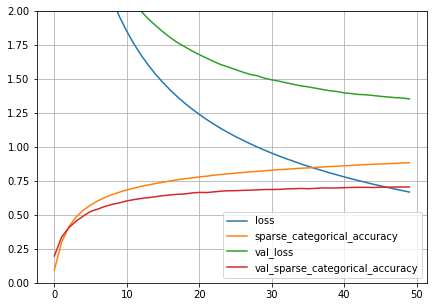

time: 267 ms (started: 2023-02-21 01:22:11 +00:00)


In [ ]:
plot_loss(history)

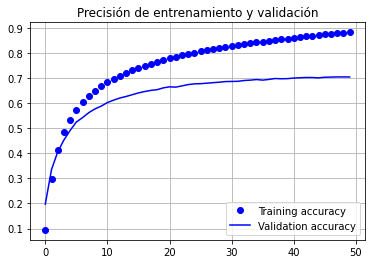

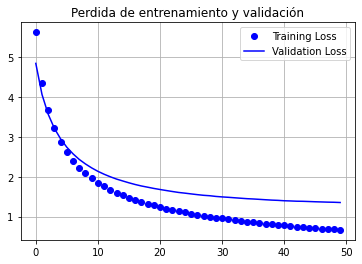

time: 565 ms (started: 2023-02-21 01:22:11 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/inverted/model_densenet121_etl8_imgs64_inverted__OTSU.h5-------
time: 3.77 s (started: 2023-02-21 01:22:12 +00:00)


# Imgs 96x96

- Test Accuracy: 0.7308939695358276
- Test Loss: 1.251461148262024
- time: 56min 16s
- F1 score: 0.7312718599679328
- Precision score: 0.7491219995232545
- Recall:  0.7308939650310209
- Epoch: 50/50


## Cargar las imágenes

In [ ]:
SIZE = 96 # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

PATH = ROOT_PATH.format(SIZE)

time: 660 µs (started: 2023-02-21 01:35:27 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 9.15 s (started: 2023-02-21 01:35:28 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (106380, 96, 96, 1) and labels: (106380,)

- val images: (21276, 96, 96, 1) and labels: (21276,)


time: 1.39 ms (started: 2023-02-21 01:35:37 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2.87 s (started: 2023-02-21 01:35:37 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 96, 96, 3)    0           ['input_2[0][0]',                
                                                                  'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 102, 102, 3)  0          ['concatenate_1[0][0]']          
 D)                                                                                         

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 77s 21ms/step - loss: 5.6026 - sparse_categorical_accuracy: 0.1094 - val_loss: 4.8273 - val_sparse_categorical_accuracy: 0.2201
Epoch 2/50
3325/3325 [==============================] - 68s 20ms/step - loss: 4.3198 - sparse_categorical_accuracy: 0.3196 - val_loss: 4.0578 - val_sparse_categorical_accuracy: 0.3512
Epoch 3/50
3325/3325 [==============================] - 68s 20ms/step - loss: 3.6556 - sparse_categorical_accuracy: 0.4353 - val_loss: 3.5706 - val_sparse_categorical_accuracy: 0.4278
Epoch 4/50
3325/3325 [==============================] - 67s 20ms/step - loss: 3.2054 - sparse_categorical_accuracy: 0.5075 - val_loss: 3.2225 - val_sparse_categorical_accuracy: 0.4760
Epoch 5/50
3325/3325 [==============================] - 68s 20ms/step - loss: 2.8728 - sparse_categorical_accuracy: 0.5558 - val_loss: 2.9561 - val_sparse_categorical_accuracy: 0.5110
Epoch 6/50
3325/3325 [==============================] - 67s 20ms/step - loss: 2.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.31 s (started: 2023-02-21 02:31:59 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 9s 16ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7308939695358276
- Test Loss: 1.251461148262024
- time: 
- F1 score: 0.7312718599679328
- Precision score: 0.7491219995232545
- Recall:  0.7308939650310209
- Epoch: 
*********************************************************************************************************************************
time: 17.3 s (started: 2023-02-21 02:32:01 +00:00)


## Graficando

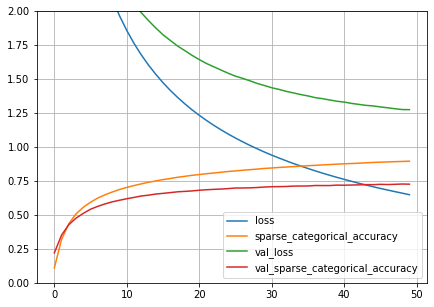

time: 201 ms (started: 2023-02-21 02:32:18 +00:00)


In [ ]:
plot_loss(history)

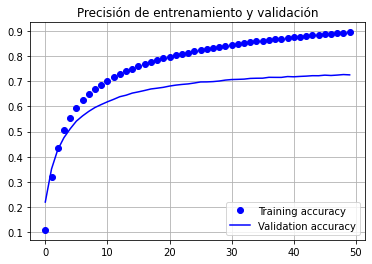

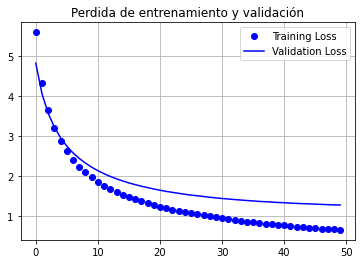

time: 385 ms (started: 2023-02-21 02:32:19 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/inverted/model_densenet121_etl8_imgs96_inverted__OTSU.h5-------
time: 845 ms (started: 2023-02-21 02:32:19 +00:00)


# Imgs 112x112

- Test Accuracy: 0.7641708850860596
- Test Loss: 1.0622766017913818
- time: 1h 54s
- F1 score: 0.7643351552755218
- Precision score: 0.7796684827624484
- Recall:  0.76417089678511
- Epoch: 50/50


## Cargar imágenes

In [ ]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 571 µs (started: 2023-02-21 02:32:20 +00:00)


In [ ]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 10.3 s (started: 2023-02-21 02:32:20 +00:00)


In [ ]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 112, 112, 1) and labels: (106380,)

- val images: (21276, 112, 112, 1) and labels: (21276,)

time: 881 µs (started: 2023-02-21 02:32:30 +00:00)


## Preparar el modelo

In [ ]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

time: 2.9 s (started: 2023-02-21 02:32:30 +00:00)


In [ ]:
print(custom_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 112, 112, 3)  0           ['input_3[0][0]',                
                                                                  'input_3[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 118, 118, 3)  0          ['concatenate_2[0][0]']    

## Entrenar el modelo

In [ ]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 80s 22ms/step - loss: 5.4226 - sparse_categorical_accuracy: 0.1344 - val_loss: 4.5417 - val_sparse_categorical_accuracy: 0.2688
Epoch 2/50
3325/3325 [==============================] - 69s 21ms/step - loss: 3.9720 - sparse_categorical_accuracy: 0.3809 - val_loss: 3.6757 - val_sparse_categorical_accuracy: 0.4179
Epoch 3/50
3325/3325 [==============================] - 70s 21ms/step - loss: 3.2526 - sparse_categorical_accuracy: 0.5059 - val_loss: 3.1494 - val_sparse_categorical_accuracy: 0.5009
Epoch 4/50
3325/3325 [==============================] - 71s 21ms/step - loss: 2.7829 - sparse_categorical_accuracy: 0.5779 - val_loss: 2.7982 - val_sparse_categorical_accuracy: 0.5452
Epoch 5/50
3325/3325 [==============================] - 72s 22ms/step - loss: 2.4471 - sparse_categorical_accuracy: 0.6262 - val_loss: 2.5330 - val_sparse_categorical_accuracy: 0.5815
Epoch 6/50
3325/3325 [==============================] - 71s 21ms/step - loss: 2.

In [ ]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.19 s (started: 2023-02-21 03:33:30 +00:00)


In [ ]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 10s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7641708850860596
- Test Loss: 1.0622766017913818
- time: 
- F1 score: 0.7643351552755218
- Precision score: 0.7796684827624484
- Recall:  0.76417089678511
- Epoch: 
*********************************************************************************************************************************
time: 18.7 s (started: 2023-02-21 03:33:32 +00:00)


## Graficando

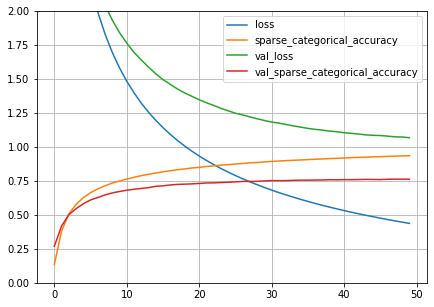

time: 199 ms (started: 2023-02-21 03:33:51 +00:00)


In [ ]:
plot_loss(history)

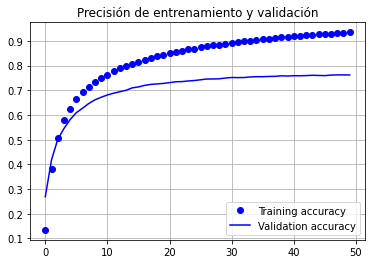

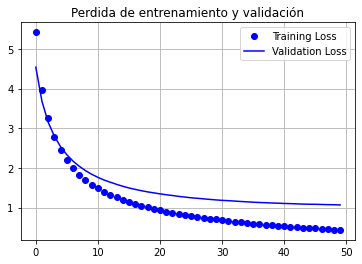

time: 392 ms (started: 2023-02-21 03:33:51 +00:00)


In [ ]:
show_history(history)

In [ ]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/inverted/model_densenet121_etl8_imgs112_inverted__OTSU.h5-------
time: 859 ms (started: 2023-02-21 03:33:51 +00:00)


# Imgs 127x127

- Test Accuracy: 0.8014664649963379
- Test Loss: 0.8812105059623718
- time: 58min 9s
- F1 score: 0.8020700195191349
- Precision score: 0.8160632056205056
- Recall:  0.8014664410603497
- Epoch: 50/50


## Cargar las imágenes

In [7]:
SIZE = 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

time: 592 µs (started: 2023-02-21 12:39:17 +00:00)


In [8]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 13.5 s (started: 2023-02-21 12:39:18 +00:00)


In [9]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (106380, 127, 127, 1) and labels: (106380,)

- val images: (21276, 127, 127, 1) and labels: (21276,)

time: 1.19 ms (started: 2023-02-21 12:39:31 +00:00)


## Preparar el modelo

In [10]:
custom_model = create_custom_model(NUM_CLASSES, WIDTH_SHAPE, HEIGHT_SHAPE, CHANNEL)

29084464/29084464 [==============================] - 0s 0us/step
time: 6.94 s (started: 2023-02-21 12:39:31 +00:00)


In [11]:
print(custom_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 127, 127, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 127, 127, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 133, 133, 3)  0          ['concatenate[0][0]']        

## Entrenar el modelo

In [12]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
3325/3325 [==============================] - 86s 22ms/step - loss: 5.3637 - sparse_categorical_accuracy: 0.1428 - val_loss: 4.4123 - val_sparse_categorical_accuracy: 0.2970
Epoch 2/50
3325/3325 [==============================] - 68s 21ms/step - loss: 3.8030 - sparse_categorical_accuracy: 0.4125 - val_loss: 3.4786 - val_sparse_categorical_accuracy: 0.4525
Epoch 3/50
3325/3325 [==============================] - 68s 21ms/step - loss: 3.0414 - sparse_categorical_accuracy: 0.5425 - val_loss: 2.9281 - val_sparse_categorical_accuracy: 0.5352
Epoch 4/50
3325/3325 [==============================] - 68s 21ms/step - loss: 2.5581 - sparse_categorical_accuracy: 0.6154 - val_loss: 2.5588 - val_sparse_categorical_accuracy: 0.5868
Epoch 5/50
3325/3325 [==============================] - 68s 21ms/step - loss: 2.2192 - sparse_categorical_accuracy: 0.6642 - val_loss: 2.2940 - val_sparse_categorical_accuracy: 0.6198
Epoch 6/50
3325/3325 [==============================] - 68s 20ms/step - loss: 1.

In [13]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.06 s (started: 2023-02-21 13:37:49 +00:00)


In [14]:
show_metrics(custom_model, test_images, test_labels)

444/444 [==============================] - 9s 17ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8014664649963379
- Test Loss: 0.8812105059623718
- time: 
- F1 score: 0.8020700195191349
- Precision score: 0.8160632056205056
- Recall:  0.8014664410603497
- Epoch: 
*********************************************************************************************************************************
time: 18.7 s (started: 2023-02-21 13:37:50 +00:00)


## Graficando


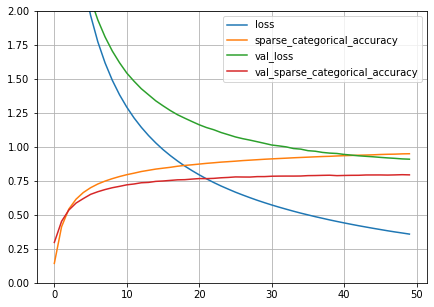

time: 272 ms (started: 2023-02-21 13:38:09 +00:00)


In [15]:
plot_loss(history)

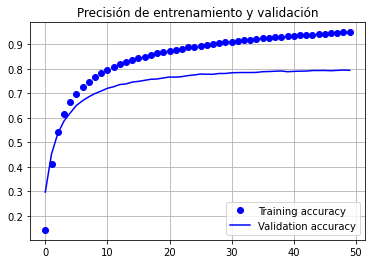

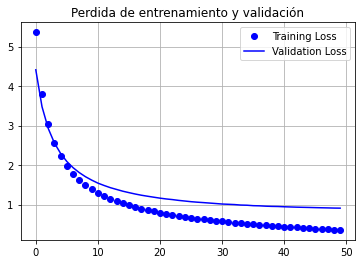

time: 396 ms (started: 2023-02-21 13:38:09 +00:00)


In [16]:
show_history(history)

In [17]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, DNN_NAME, USE_DATA_AUG)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/DenseNet121/weights_densenet121/sin_DA/inverted/model_densenet121_etl8_imgs127_inverted__OTSU.h5-------
time: 2.05 s (started: 2023-02-21 13:38:10 +00:00)


In [18]:
runtime.unassign() 

time: 196 ms (started: 2023-02-21 13:38:12 +00:00)
